/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Selected features:  ['winner_age', 'loser_age', 'winner_rank', 'w_svpt', 'l_svpt', 'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon', 'w_SvGms', 'l_SvGms', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced']
Accuracy:  0.9681753889674681
Precision:  0.9511677282377919
Recall:  0.9531914893617022
F1-score:  0.9521785334750266
Cross-Validation Scores:  [0.95402299 0.95490716 0.96286472 0.96460177 0.96902655]
Mean CV Accuracy:  0.9610846380757885


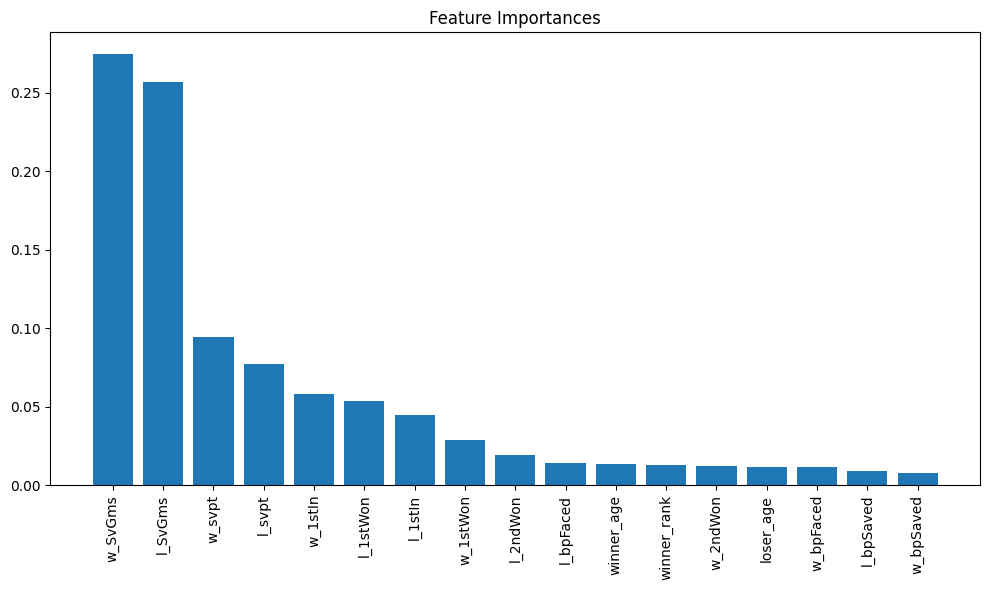

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib

# Load historical matches data
urls = ['https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2020.csv',
        'https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2021.csv',
        'https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2022.csv',
        'https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2023.csv']
wta_matches = pd.concat((pd.read_csv(url) for url in urls))

# Data cleaning and processing code...
# Remove 'RET', 'W/O' and any content inside parentheses '(...)'
wta_matches['score'] = wta_matches['score'].str.replace(r'\(.*\)|RET|W/O', '', regex=True)
# Remove any leading or trailing white spaces
wta_matches['score'] = wta_matches['score'].str.strip()
na_in_score = wta_matches['score'].isna().sum()

# Add missing values count per row
wta_matches['missing_values'] = wta_matches.isnull().sum(axis=1)
# Define missing values groups
bins = [0, 5, 10, 15, 20, 25, 30, np.inf]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '30+']
wta_matches['missing_values_group'] = pd.cut(wta_matches['missing_values'], bins=bins, labels=labels)

# Drop rows with too many missing values
groups_to_drop = ['21-25', '26-30', '30+']
rows_to_drop = wta_matches['missing_values_group'].isin(groups_to_drop)
wta_matches = wta_matches[~rows_to_drop]

# Mean imputation for remaining missing values
for column in wta_matches.columns:
    if wta_matches[column].isnull().any():
        if wta_matches[column].dtype in ['int64', 'float64']:
            wta_matches[column].fillna(wta_matches[column].mean(), inplace=True)

# Calculate player performance statistics
wins = wta_matches.groupby('winner_name').size().reset_index(name='wins')
losses = wta_matches.groupby('loser_name').size().reset_index(name='losses')
player_performance = pd.merge(wins, losses, how='outer', left_on='winner_name', right_on='loser_name')
player_performance.fillna(0, inplace=True)
player_performance['win_rate'] = player_performance['wins'] / (player_performance['wins'] + player_performance['losses'])
player_performance['player_name'] = np.where(player_performance['wins'] > player_performance['losses'], player_performance['winner_name'], player_performance['loser_name'])
player_performance.drop(columns=['winner_name', 'loser_name'], inplace=True)

# Merge player performance statistics with the main dataset
wta_matches = pd.merge(wta_matches, player_performance, how='left', left_on='winner_name', right_on='player_name')
wta_matches.drop(columns=['player_name'], inplace=True)

# Calculate number of sets for each match
wta_matches['total_sets'] = wta_matches['score'].str.count(' ')

# Create a binary target: 1 if total_sets > 1 (match ended in 3 sets), 0 otherwise
wta_matches['over_2.5_sets'] = (wta_matches['total_sets'] > 1).astype(int)

# Filter out matches with less than 2 sets
wta_matches = wta_matches[wta_matches['total_sets'] >= 1]

target = 'over_2.5_sets'
# One-hot encode 'surface' and 'tourney_level' 
encoded_features = pd.get_dummies(wta_matches[['surface', 'tourney_level']])

# Drop the original 'surface' and 'tourney_level' columns
wta_matches = wta_matches.drop(['surface', 'tourney_level'], axis=1)

# Concatenate the original DataFrame and the one-hot encoded features
wta_matches = pd.concat([wta_matches, encoded_features], axis=1)

# Update the 'features' list
features = ['winner_age', 'loser_age', 'winner_rank', 'loser_rank',
            'winner_ht', 'loser_ht', 'w_ace', 'l_ace', 'w_df', 'l_df', 'w_svpt', 'l_svpt',
            'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon',
            'w_SvGms', 'l_SvGms', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced'] + list(encoded_features.columns)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(wta_matches[features], wta_matches[target], test_size=0.2, random_state=42)

# Perform feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42)
selector = SelectFromModel(clf, threshold='median')
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
selected_features = [features[i] for i in range(len(features)) if selector.get_support()[i]]
print("Selected features: ", selected_features)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)

# Save the trained estimator
joblib.dump(best_estimator, 'trained_estimator.pkl')

# Save the selected features
joblib.dump(selected_features, 'selected_features.pkl')

# Predict on the test set
y_pred = best_estimator.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

# Perform cross-validation
cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Accuracy: ", cv_scores.mean())

# Get feature importances
importances = best_estimator.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), np.array(selected_features)[indices], rotation=90)
plt.tight_layout()
plt.show()

# Save the preprocessed data as a file
wta_matches.to_csv('preprocessed_data.csv', index=False)